In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cf

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw

## Compute the Extremes quantiles using GEV

In [2]:
# product = 'IMERG'
# product = 'ERA5'
# product = 'MSWEP'
# product = 'CMORPH'
# product = 'GSMaP'
product = 'CHIRPS'

In [3]:
dir_base =os.path.join('/','media','arturo','T9','Data','Italy','Satellite')
print(f'Product: {product}')

if product == 'IMERG':
    data_dir = os.path.join(dir_base,'IMERG','1dy','IMERG_Italy_1dy_2000_06_01_2024_02_29.nc')
elif product == 'MSWEP':
    data_dir = os.path.join(dir_base,'MSWEP','3h','MSWEP_Italy_3h_1980_01_01_2023_12_31.nc')
elif product == 'ERA5':
    data_dir = os.path.join(dir_base,'ERA5','3h','ERA5_Italy_3h_2000_01_01_2023_12_31.nc')
elif product == 'CMORPH':
    data_dir = os.path.join(dir_base,'CMORPH','3h','CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc')
elif product == 'GSMaP':
    data_dir = os.path.join(dir_base,'GSMaP','3h','GSMaP_Italy_3h_2002_01_01_2024_12_31.nc')
elif product == 'CHIRPS':
    data_dir = os.path.join(dir_base,'CHIRPS','1dy','CHIRPS_Italy_1dy_1981_01_01_2024_06_30.nc')
else:
    raise ValueError(f'Product {product} not recognized. Please choose from: IMERG, MSWEP, ERA5, CMORPH, GSMaP, CHIRPS.')

Product: CHIRPS


In [4]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

In [5]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'DEM','Italy_dem_800.geojson'))   
else:
    raise SystemExit(f"File not found: {veneto_dir}")

# update name of REGIONS geopandas
REGIONS = REGIONS.rename(columns={"reg_name": "Region"})
REGIONS['Region'] = REGIONS['Region'].replace('Emilia Romagna', 'Emilia-Romagna')

In [6]:
DATA = xr.open_dataset(data_dir)

lons, lats = DATA['lon'].values, DATA['lat'].values
nlon, nlat = len(lons), len(lats)
lon2d, lat2d = np.meshgrid(lons, lats)

if product == 'CHIRPS' or product == 'IMERG':
    PRE = DATA['PRE'].values
else:
    PRE = DATA['PRE'].resample(time="1D").sum()

In [7]:
Tr = np.array([5, 10, 20, 50, 100, 200])
Fi = 1-1/Tr
thresh = 1

Qev = np.zeros([6, nlat, nlon])
for i in range(nlat):
    for j in range(nlon):
        tmp = PRE[:, i, j]
        test = tmp[~np.isnan(tmp)]
        c_excesses = test[test > thresh] - thresh
        try:
            web_fit = DOWN_raw.gev_fit_lmom(c_excesses)
        except:
            web_fit = (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
        Qev[:,i,j] = DOWN_raw.gev_quant(Fi, web_fit[0], web_fit[1], web_fit[2])

/home/arturo/github/downpy/function/DOWN_raw.py:1234: RuntimeWarning: invalid value encountered in scalar divide
  b0 = np.sum(x) / n


Text(1.0, 1.0, 'Return Time: 50 yrs')

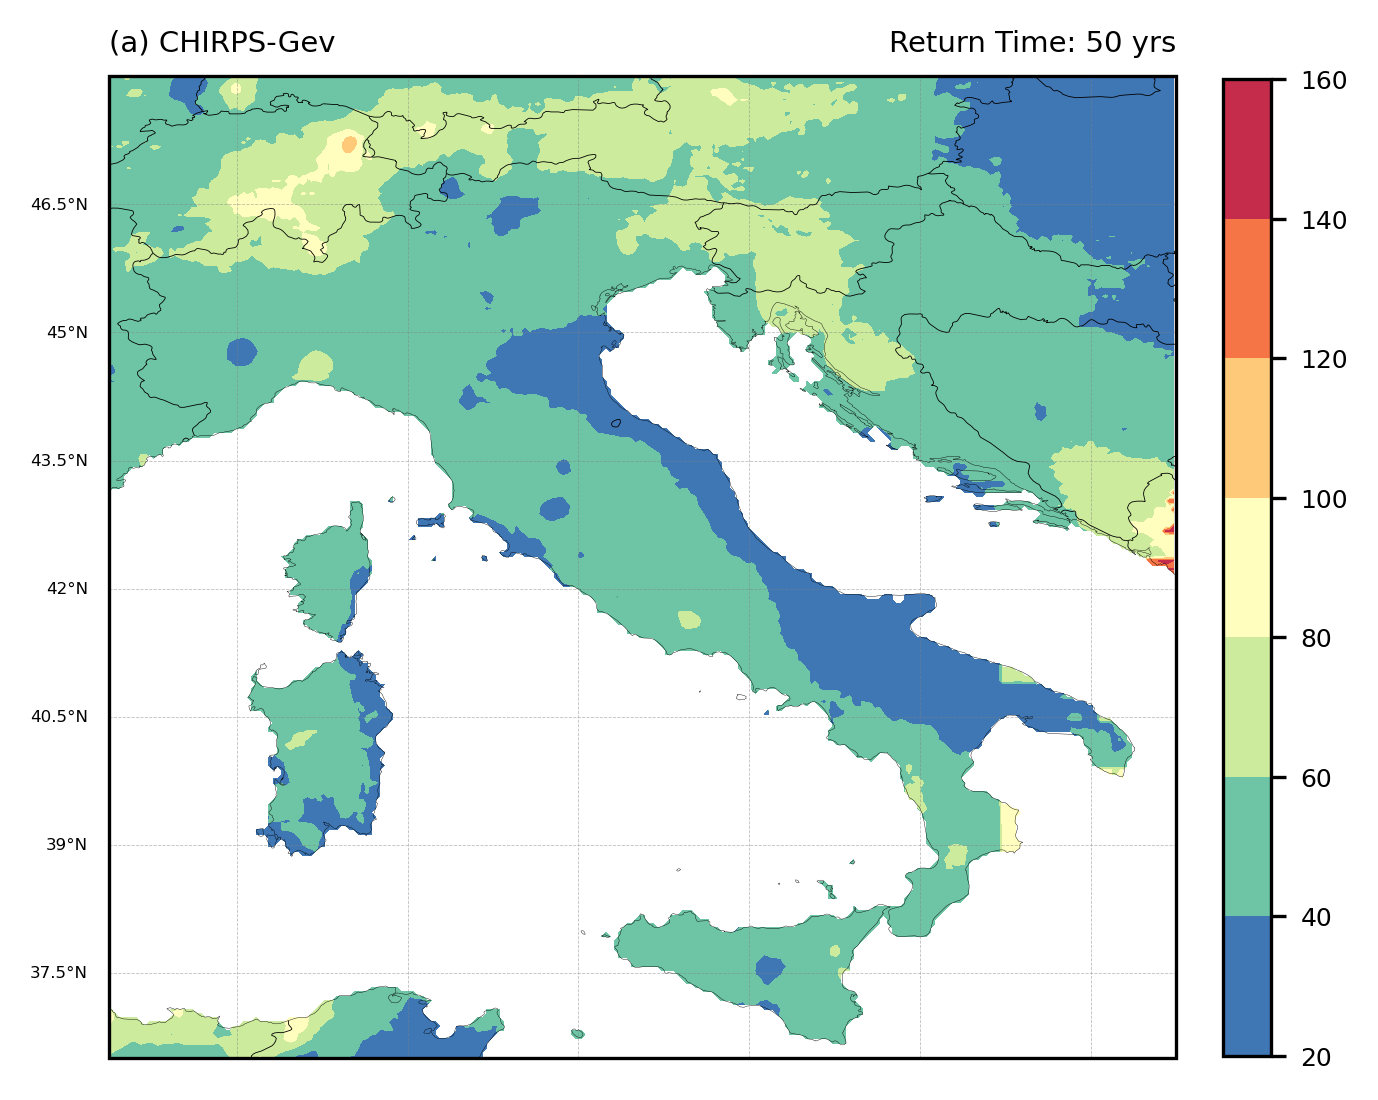

In [8]:
yy = 3

levels = np.arange(10, 320, 20)
levels = None

Mev_cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,1)

# ===========================================================================================================================================================================
# ===========================================================================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1,edgecolor='k')
ax1.add_feature(cf.BORDERS,linewidth=0.2,edgecolor='black',zorder=4)

a1 = ax1.contourf(lon2d, lat2d, Qev[yy,:,:], cmap=Mev_cmap, levels=levels)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = True

gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.042, pad=0.04)
cbar.ax.tick_params(labelsize=6) 

ax1.set_title(f'(a) {product}-Gev', fontsize=7, loc='left')
ax1.set_title(f'Return Time: {Tr[yy]} yrs', fontsize=7, loc='right')


In [9]:
DATA_xr = xr.Dataset(data_vars={"GEV": (("time","lat","lon"), Qev)},
                    coords={'Tr': Tr, 'lat': lats, 'lon': lons},
                    attrs=dict(description=f"{product} GEV quantile q for given non exceedance probabilities in Fi for Italy region"))

DATA_xr.GEV.attrs["units"] = "mm/day"
DATA_xr.GEV.attrs["long_name"] = "GEV quantile"
DATA_xr.GEV.attrs["origname"] = "GEV"

DATA_xr.lat.attrs["units"] = "degrees_north"
DATA_xr.lat.attrs["long_name"] = "Latitude"

DATA_xr.lon.attrs["units"] = "degrees_east"
DATA_xr.lon.attrs["long_name"] = "Longitude"

In [10]:
name_out = data_dir.split('/')[-1].replace(product,f'GEV_{product}')
dir_out = os.path.join(dir_base, '0_GEV', name_out)
print(f'Export as: {dir_out}')
# DATA_xr.to_netcdf(dir_out)

Export as: /media/arturo/T9/Data/Italy/Satellite/0_GEV/GEV_CHIRPS_Italy_1dy_1981_01_01_2024_06_30.nc


In [11]:
sys.exit()

SystemExit: 

/home/arturo/anaconda3/envs/AXE/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Compare products

In [15]:
dir_out = os.path.join(dir_base, '0_GEV')

In [16]:
CHIRPS_dir = os.path.join(dir_out,'GEV_CHIRPS_Italy_1dy_1981_01_01_2024_06_30.nc')
IMERG_dir = os.path.join(dir_out,'GEV_IMERG_Italy_1dy_2000_06_01_2024_02_29.nc')
CMORPH_dir = os.path.join(dir_out,'GEV_CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc')
MSWEP_dir = os.path.join(dir_out,'GEV_IMERG_Italy_1dy_2000_06_01_2024_02_29.nc')
ERA5_dir = os.path.join(dir_out,'GEV_ERA5_Italy_3h_2000_01_01_2023_12_31.nc')
GSMaP_dir = os.path.join(dir_out,'GEV_GSMaP_Italy_3h_2002_01_01_2024_12_31.nc')

In [29]:
DATA = xr.open_dataset(CHIRPS_dir)
lon2d_CH, lat2d_CH = np.meshgrid(DATA['lon'].values, DATA['lat'].values)
CH_GEV = DATA['GEV'].values[3,:,:]

In [30]:
DATA = xr.open_dataset(IMERG_dir)
lon2d_IM, lat2d_IM = np.meshgrid(DATA['lon'].values, DATA['lat'].values)
IM_GEV = DATA['GEV'].values[3,:,:]

In [31]:
DATA = xr.open_dataset(CMORPH_dir)
lon2d_CM, lat2d_CM = np.meshgrid(DATA['lon'].values, DATA['lat'].values)
CM_GEV = DATA['GEV'].values[3,:,:]

In [32]:
DATA = xr.open_dataset(MSWEP_dir)
lon2d_MS, lat2d_MS = np.meshgrid(DATA['lon'].values, DATA['lat'].values)
MS_GEV = DATA['GEV'].values[3,:,:]

In [33]:
DATA = xr.open_dataset(ERA5_dir)
lon2d_ER, lat2d_ER = np.meshgrid(DATA['lon'].values, DATA['lat'].values)
ER_GEV = DATA['GEV'].values[3,:,:]

In [34]:
DATA = xr.open_dataset(GSMaP_dir)
lon2d_GS, lat2d_GS = np.meshgrid(DATA['lon'].values, DATA['lat'].values)
GS_GEV = DATA['GEV'].values[3,:,:]

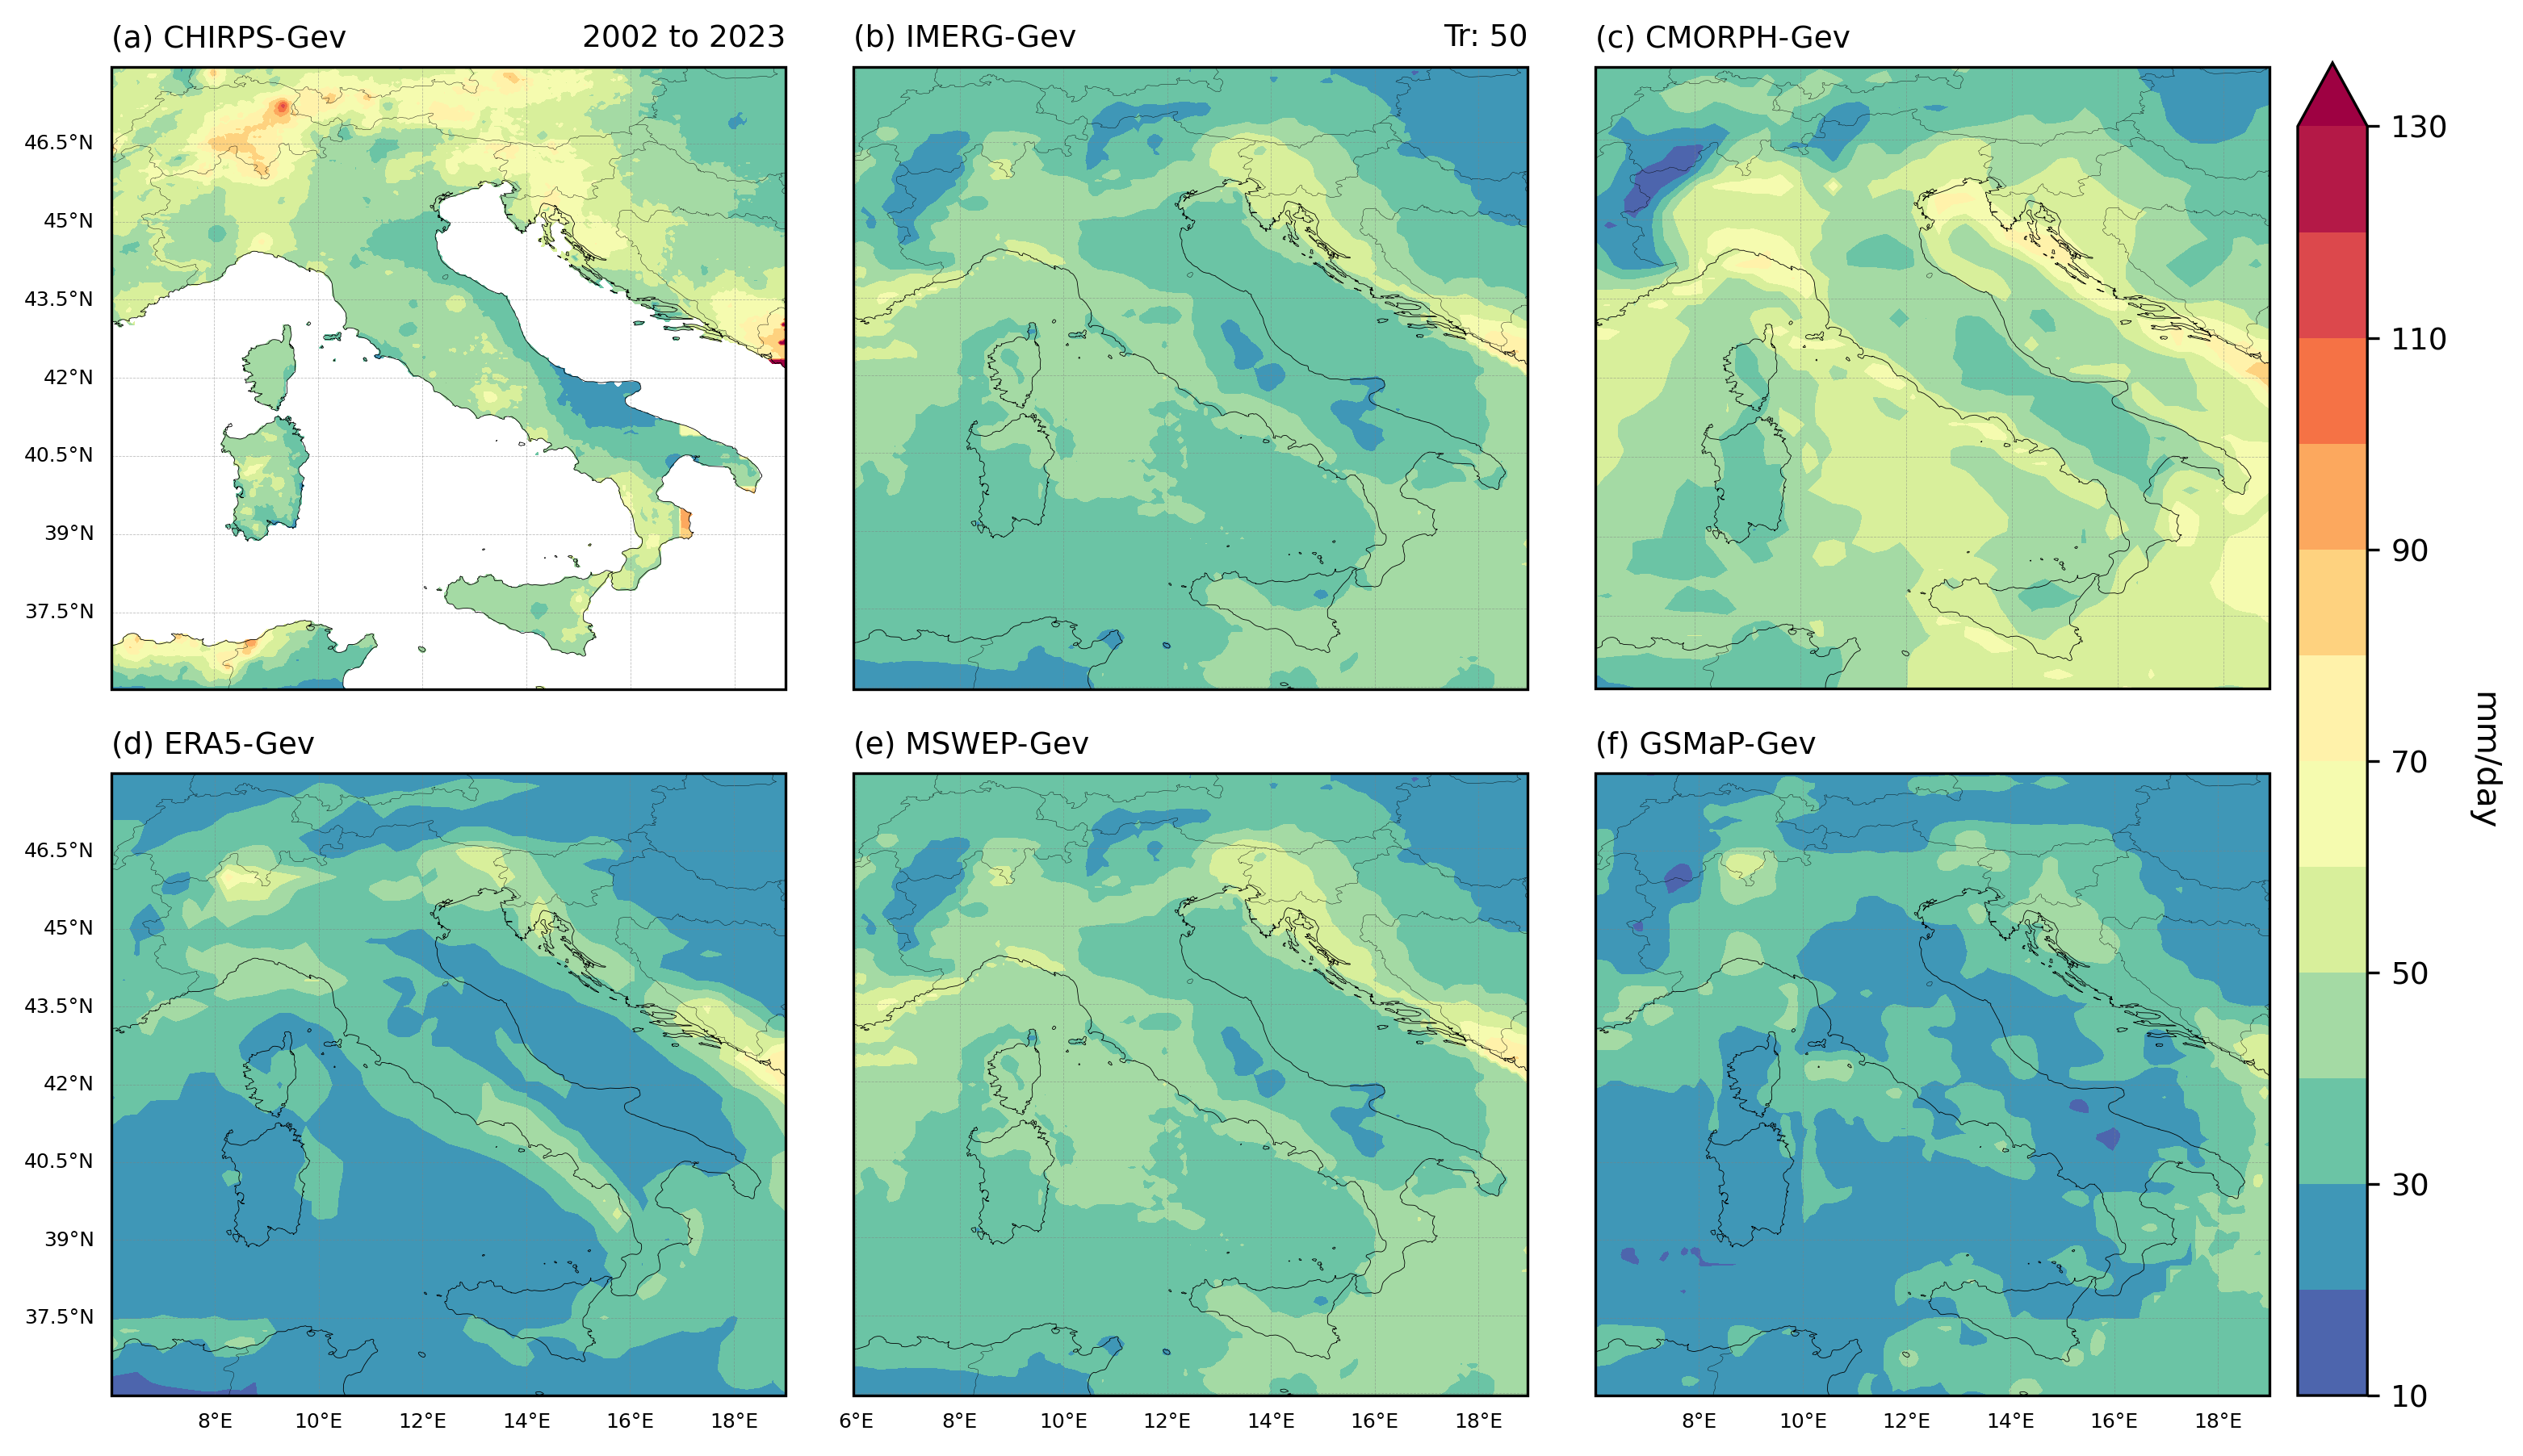

In [66]:
levels = np.arange(10, 140, 10)
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(11.5,8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d_CH, lat2d_CH, CH_GEV, cmap=cmap, levels=levels, extend='max')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

ax1.set_title('(a) CHIRPS-Gev', loc='left', fontsize=9)
ax1.set_title('2002 to 2023', loc='right', fontsize=9)

# cbar = plt.colorbar(a1, fraction=0.043, pad=0.06, orientation='horizontal')
# cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d_IM, lat2d_IM, IM_GEV, cmap=cmap, levels=levels, extend='max')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

ax1.set_title('(b) IMERG-Gev', loc='left', fontsize=9)
ax1.set_title(f'Tr: {Tr[3]}', loc='right', fontsize=9)

# cbar = plt.colorbar(a1, fraction=0.043, pad=0.06, orientation='horizontal')
# cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d_CM, lat2d_CM, CM_GEV, cmap=cmap, levels=levels, extend='max')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

ax1.set_title('(c) CMORPH-Gev', loc='left', fontsize=9)

# cbar = plt.colorbar(a1, fraction=0.043, pad=0.06, orientation='horizontal')
# cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d_ER, lat2d_ER, ER_GEV, cmap=cmap, levels=levels, extend='max')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

ax1.set_title('(d) ERA5-Gev', loc='left', fontsize=9)

# cbar = plt.colorbar(a1, fraction=0.043, pad=0.06, orientation='horizontal')
# cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d_MS, lat2d_MS, MS_GEV, cmap=cmap, levels=levels, extend='max')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

ax1.set_title('(e) MSWEP-Gev', loc='left', fontsize=9)

# cbar = plt.colorbar(a1, fraction=0.043, pad=0.06, orientation='horizontal')
# cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.2, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

a1 = ax1.contourf(lon2d_GS, lat2d_GS, GS_GEV, cmap=cmap, levels=levels, extend='max')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 6, 'color': 'k'}
gl.ylabel_style = {'size': 6, 'color': 'k'}

ax1.set_title('(f) GSMaP-Gev', loc='left', fontsize=9)

# cbar = plt.colorbar(a1, fraction=0.043, pad=0.06, orientation='horizontal')
# cbar.ax.tick_params(labelsize=5)

# ============================================================================================================================
plt.subplots_adjust(hspace=0.01,wspace=0.05)

cbar_ax = fig.add_axes([0.91, 0.152, 0.025, 0.688])#0.91
cbar = plt.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_ylabel('mm/day', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

# ============================================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=-0.1, wspace=0.1)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)
